# Korteweg-deVries Equation

$$
u_t + u u_x + \mu u_{xxx} = 0 \qquad (0 < x < 1)
$$

See [Interaction of "Solitons" in a Collisionless Plasma and the Recurrence of Initial States
](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.15.240) (N. J. Zabusky and M. D. Kruskal
Phys. Rev. Lett., Vol. 15, 240, 1965).

It does not seem that the solution returns to the initial state exactly, though it gets close. I don't know why. More accurate schemes might be needed.

## Importing modules 

In [1]:
import time

import numpy as np
import equations as eq

import h5py

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.parasite_axes import HostAxes
import matplotlib.transforms as mtransforms

In [2]:
import panel as pn

## Setting Parameters 

In [3]:
NW = 50
kdv01 = eq.KdV(NW)
args = kdv01.getParamDefault()

J = kdv01.J
x = kdv01.sc.get_x()

## Setting initial data 

In [4]:
w0p = np.cos(2.0*np.pi*x).reshape((1,J))
w0c = kdv01.sc.transform_wp2wc(w0p)

## Preparation

In [5]:
trange = np.linspace(0., 6.0, 601)
max_step = 1.0e-1
fname = 'kdv.hdf5'

## Computation

In [6]:
with h5py.File(fname, 'w') as fh:
    kdv01.mkInitDataSet(w0c, fh)
    kdv01.evolve(fh, trange, tuple(args), 
                max_step=max_step, method='Radau', pb_type="notebook")

  0%|          | 0/6 [00:00<?, ?it/s]

## Visualization

In [7]:
with h5py.File(fname, 'r') as fh:
    wp = fh['wp'][()]
    powers = fh['powerspec'][()]
    atime = fh['trange'][()]

In [8]:
freq_max = NW
freq = np.arange(NW)

In [9]:
gsWS = GridSpec(1,2)
gsT = GridSpec(1,1)
gsWS.update(bottom=0.25, top=0.8, right=0.8)
gsT.update(bottom=0.05, top=0.2)

def create_plotter():
    fig = plt.figure(figsize=(6,4));
    
    ax_ph = fig.add_subplot(gsWS[0,0])
    ax_ph.set_ylim((-1.2, 3.0))
    ax_ph.set_xlim((-0.1, 1.1))
    ax_ph.grid(True)
    ax_ph.set_xlabel('x')
    ax_ph.set_ylabel('u')
    
    ax_spec = fig.add_subplot(gsWS[0,1])
    ax_spec.yaxis.set_ticks_position('right')
    ax_spec.yaxis.set_label_position('right')
    ax_spec.set_xlim((0., NW))
    ax_spec.set_ylim(-0.05, 0.3)
    ax_spec.set_xlabel('mode')
    ax_spec.set_ylabel('power')
    ax_spec.grid(True)
    
    
    lines = ax_ph.plot(x, [np.nan]*len(x));
    
    pow_specs = ax_spec.plot(
        freq[:freq_max],
        [np.nan]*freq_max,
        color=(1.0, 0.0, 0.0, 0.4)
        )
    
    timeframe = fig.add_subplot(gsT[0])
    timeframe.set_axis_off()
    timer = timeframe.text(0.5,0.5,
                           '', 
                           va='center', ha="center"
                          )
    timeformat = "time = {0:05.3f}"
    plt.close()
    def plot(wp, idx):
        for l in lines:
            l.set_ydata(wp[idx, 0, :]);
        for p in pow_specs:
            p.set_ydata(powers[idx, 0, :freq_max])
        timer.set_text(timeformat.format(atime[idx]))

        return fig

    return plot


In [10]:
slider = pn.widgets.IntSlider(
    value=0,
    start=0,
    end=wp.shape[0] - 1,
    step=1,
    name="idx"
)


Column
    [0] IntSlider(end=600, name='idx')
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False)
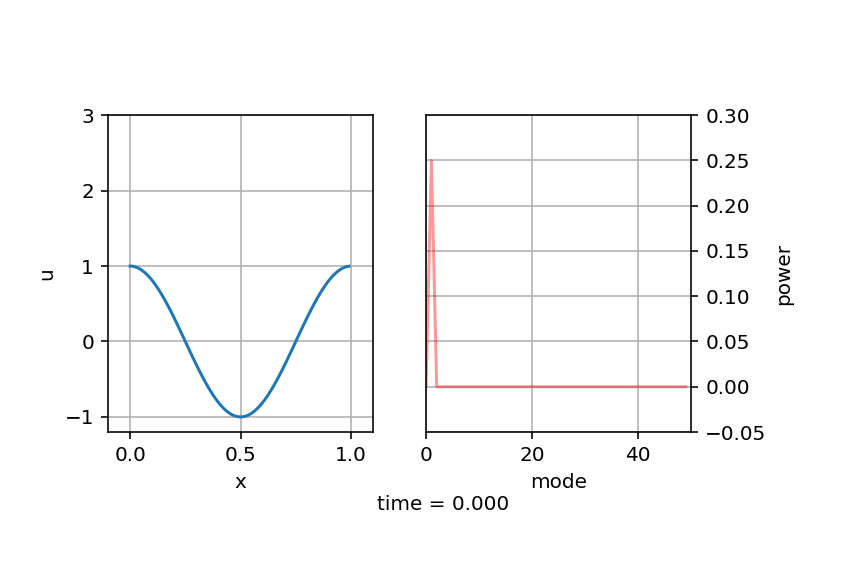

In [11]:
plot = create_plotter()
kdv_plot = pn.bind(plot, wp=wp, idx=slider)
pn.extension()
pn.Column(slider, kdv_plot).servable()